<a href="https://colab.research.google.com/github/dustinober1/Oreilly-Applied-Machine-Learning-and-AI-for-Engineers/blob/main/Chapter_6_Principal_Component_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Principal Component Analysis

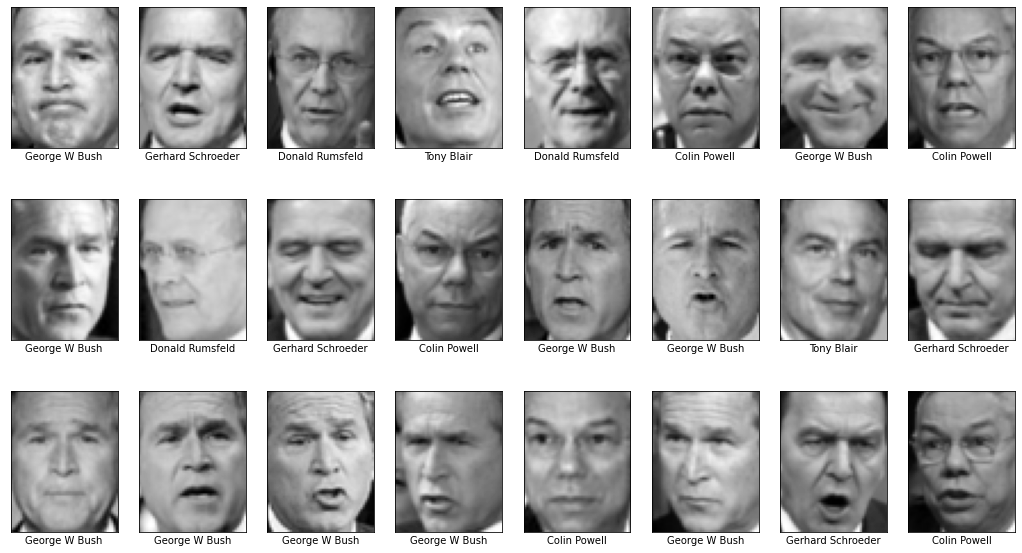

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, slice_=None)
faces.images = faces.images[:, 35:97, 39:86]
faces.data = faces.images.reshape(faces.images.shape[0], faces.images.shape[1] *
                                  faces.images.shape[2])
fig, ax = plt.subplots(3, 8, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Each image measures 47 × 62 pixels, for a total of 2,914 pixels per image. That means the dataset has 2,914 dimensions. Now use the following code to reduce the number of dimensions to 150 (roughly 5% of the original number), restore the original 2,914 dimensions, and plot the restored images:

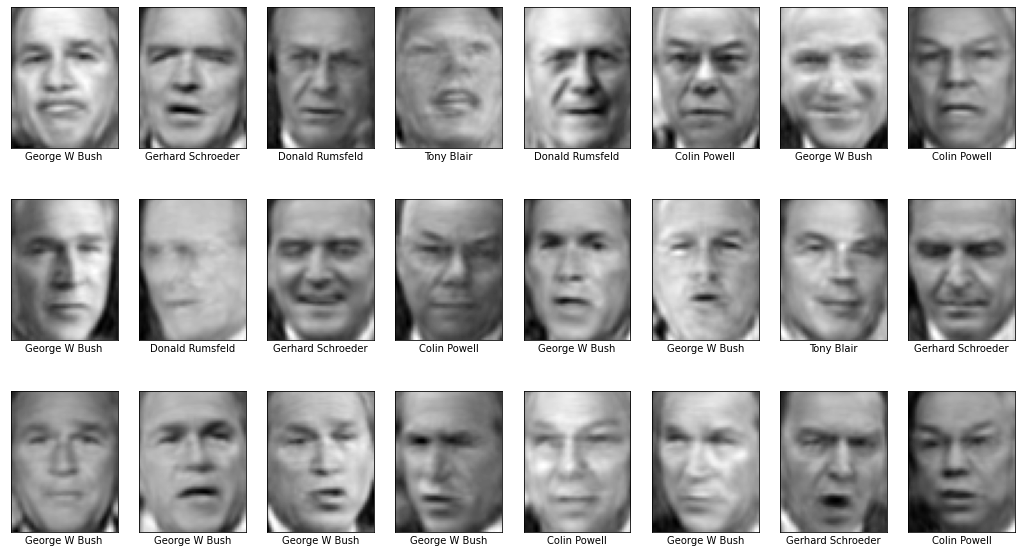

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=150, random_state=0)
pca_faces = pca.fit_transform(faces.data)
unpca_faces = pca.inverse_transform(pca_faces).reshape(1140, 62, 47)

fig, ax = plt.subplots(3, 8, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(unpca_faces[i], cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

This reveals that 20% of the variance in the dataset is explained by the primary principal component, 14% is explained by the secondary principal component, and so on. Observe that the numbers decrease as the index increases. By definition, each principal component in a PCAed dataset contains more information than the principal component after it. In this example, the 2,764 principal components that were discarded contained so little information that their loss was barely noticeable when the transform was inverted. In fact, the sum of the 150 numbers in the preceding example is 0.938. This means reducing the dataset from 2,914 dimensions to 150 retained 93.8% of the information in the original dataset. In other words, you reduced the number of dimensions by almost 95%, and yet you retained almost 94% of the information in the dataset. If that’s not awesome, I don’t know what is.

A logical question to ask is, what is the “right” number of components? In other words, what number of components strikes the best balance between reducing the number of dimensions in the dataset and retaining most of the information? One way to find that number is with a scree plot, which charts the proportion of explained variance for each dimension. The following code produces a scree plot for the PCA transform used on the facial images:



Text(0, 0.5, 'Explained Variance')

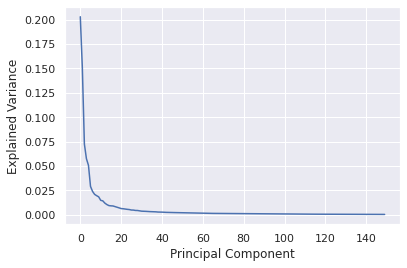

In [3]:
import seaborn as sns
sns.set()

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')

Another way to look at it is to plot the cumulative sum of the variances as a function of component count:



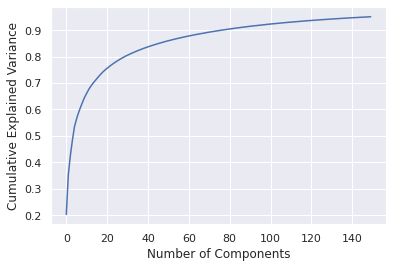

In [4]:
import numpy as np

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

## Filtering Noise

One very practical use for PCA is to filter noise from data. Noise is data that is random, corrupt, or otherwise meaningless, and it’s particularly likely to occur when the data comes from physical devices such as pressure sensors or accelerometers. The basic approach to using PCA for noise reduction is to PCA-transform the data and then invert the transform, reducing the dataset from m dimensions to n and then restoring it to m. Because PCA discards the least important information when reducing dimensions and noise tends to have little or no informational value, this ideally eliminates much of the noise while retaining most of the meaningful data.

You can test this supposition with the LFW dataset. Use the following statements to add noise to the facial images using a random-number generator and plot the first 24 images:

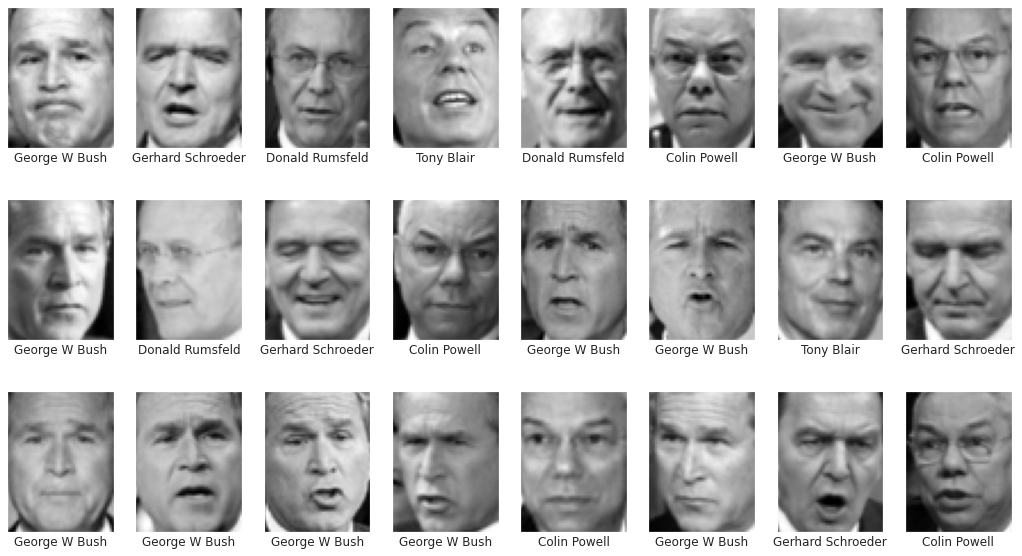

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
import numpy as np

faces = fetch_lfw_people(min_faces_per_person=100, slice_=None)
faces.images = faces.images[:, 35:97, 39:86]
faces.data = faces.images.reshape(faces.images.shape[0], faces.images.shape[1] *
                                  faces.images.shape[2])
 
np.random.seed(0)
noisy_faces = np.random.normal(faces.data, 0.0765)

fig, ax = plt.subplots(3, 8, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(noisy_faces[i].reshape(62, 47), cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Now use PCA to reduce the number of dimensions. Rather than specify the number of dimensions (components), we’ll specify that we want to reduce the amount of information in the dataset to 80%. We’ll let Scikit decide how many dimensions will remain, and then show the count:



In [6]:
from sklearn.decomposition import PCA

pca = PCA(0.8, random_state=0)
pca_faces = pca.fit_transform(noisy_faces)
pca.n_components_

30

PCA reduced the number of dimensions from 2,914 to 179, but the remaining dimensions contain 80% of the information in the original 2,914. Now reconstruct the facial images from the PCAed faces and show the results:



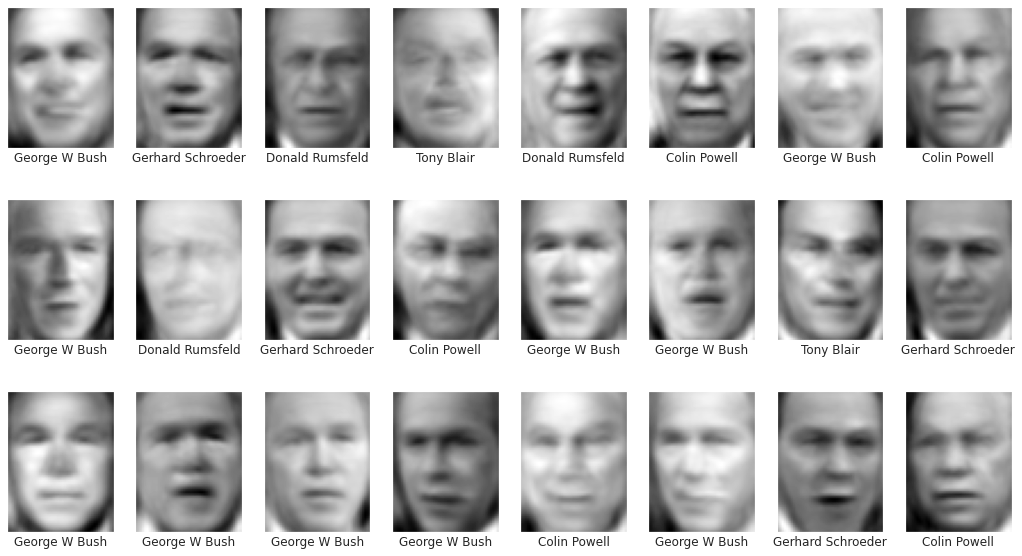

In [7]:
unpca_faces = pca.inverse_transform(pca_faces)

fig, ax = plt.subplots(3, 8, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(unpca_faces[i].reshape(62, 47), cmap='gist_gray')
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

# Anonymizing Data

Try it with a dataset of your own. First, use the following code to load Scikit’s breast cancer dataset and display the first five rows:

In [8]:
import pandas as pd
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
df = pd.DataFrame(data=data.data, columns=data.feature_names)
pd.set_option('display.max_columns', 6)
df.head()

,mean radius,mean texture,mean perimeter,...,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,...,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,...,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,...,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,...,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,...,0.1625,0.2364,0.07678


The dataset contains 30 columns, not counting the label column. Now use the following statements to find the 30 principal components and apply StandardScaler to the transformed data:



In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=30, random_state=0)
pca_data = pca.fit_transform(df)

scaler = StandardScaler()
anon_df = pd.DataFrame(scaler.fit_transform(pca_data))
pd.set_option('display.max_columns', 8)
anon_df.head()

,0,1,2,3,...,26,27,28,29
0,1.743043,-3.440692,1.832695,-1.179529,...,-1.033900,0.767070,1.406020,0.841434
1,1.906779,0.182972,-1.335313,2.418269,...,-0.043492,-0.798802,0.484854,-1.267746
2,1.496120,0.458381,-0.064503,0.568556,...,0.092680,0.010964,-0.547972,0.484234
3,-0.611764,-0.788775,0.327197,-1.592188,...,0.008095,0.811865,-1.511794,-1.978890
4,1.397781,2.216483,0.051866,1.150718,...,1.716566,0.161769,1.260500,0.390467


The dataset is unrecognizable after the PCA transform. Without the transform, it’s impossible to work backward and reconstruct the original data. Yet the sum of the explained_variance_ratio_ values is 1.0, which means no information was lost. You can prove it this way:



In [10]:
import numpy as np

np.sum(pca.explained_variance_ratio_)

1.0

# Visualizing High-Dimensional Data

Yet another use for PCA is to reduce a dataset to two or three dimensions so that it can be plotted with libraries such as Matplotlib. You can’t plot a dataset that has 1,000 columns. You can plot a dataset that has two or three columns. The fact that PCA can reduce high-dimensional data to two or three dimensions while retaining much of the original information makes it a great tool for exploring data and visualizing relationships between classes.

Suppose you’re building a classification model and want to assess up front whether there is sufficient separation between classes to support such a model. Take the Optical Recognition of Handwritten Digits dataset built into Scikit, for example. Each digit in the dataset is represented by an 8 × 8 array of pixel values, meaning the dataset has 64 dimensions. If you could plot a 64-dimensional diagram, you might be able to inspect the dataset and look for separation between classes. But 64 dimensions is 61 too many for most humans.

Enter PCA. The following code loads the dataset, uses PCA to reduce it to two dimensions, and plots the result, with different colors representing different classes (digits):



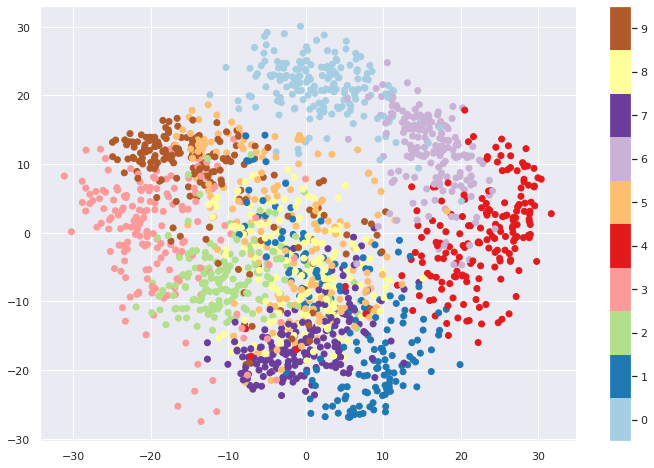

In [11]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
%matplotlib inline

digits = load_digits()
pca = PCA(n_components=2, random_state=0)
pca_digits = pca.fit_transform(digits.data)

plt.figure(figsize=(12, 8))
plt.scatter(pca_digits[:, 0], pca_digits[:, 1], c=digits.target,
            cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

You can better visualize relationships between classes with a 3D plot. The following code uses PCA to reduce the dataset to three dimensions and Mplot3D to produce an interactive plot. Note that if you run this code in Jupyter Lab, you’ll probably have to change the first line to %matplotlib widget:



In [12]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

digits = load_digits()
pca = PCA(n_components=3, random_state=0)
pca_digits = pca.fit_transform(digits.data)

ax = plt.figure(figsize=(12, 8)).add_subplot(111, projection='3d')
ax.scatter(xs = pca_digits[:, 0], ys = pca_digits[:, 1], zs = pca_digits[:, 2],
           c=digits.target, cmap=plt.cm.get_cmap('Paired', 10))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PCA isn’t the only way to reduce a dataset to two or three dimensions for plotting. You can also use Scikit’s Isomap class or its TSNE class. TSNE implements t-distributed stochastic neighbor embedding, or t-SNE for short. t-SNE is a dimensionality reduction algorithm that is used almost exclusively for visualizing high-dimensional data. Whereas PCA uses a linear function to transform data, t-SNE uses a nonlinear transform that tends to heighten the separation between classes by keeping similar data points close together in low-dimensional space. (PCA, by contrast, focuses on keeping dissimilar points far apart.) Here’s an example that plots the Digits dataset in two dimensions after reducing it with t-SNE:



/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


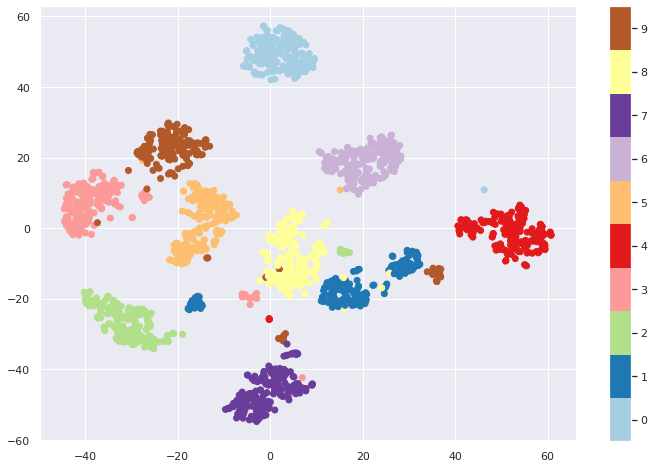

In [13]:
%matplotlib inline
from sklearn.manifold import TSNE

digits = load_digits()
tsne = TSNE(n_components=2, init='pca', learning_rate='auto',
            random_state=0)
tsne_digits = tsne.fit_transform(digits.data)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_digits[:, 0], tsne_digits[:, 1], c=digits.target,
            cmap=plt.cm.get_cmap('Paired', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

# Using PCA to Detect Credit Card Fraud

Supervised learning isn’t the only option for detecting credit card fraud. Here’s an alternative approach that uses PCA-based anomaly detection to identify fraudulent transactions. Begin by loading the dataset, separating the samples by class into one dataset representing legitimate transactions and another representing fraudulent transactions, and dropping the Time and Class columns. If you didn’t download the dataset in Chapter 3, you can get it now from the ZIP file.



In [15]:
import pandas as pd

df = pd.read_csv('creditcard.csv')
df.head()

# Separate the samples by class
legit = df[df['Class'] == 0]
fraud = df[df['Class'] == 1]

# Drop the "Time" and "Class" columns
legit = legit.drop(['Time', 'Class'], axis=1)
fraud = fraud.drop(['Time', 'Class'], axis=1)

Use PCA to reduce the two datasets from 29 to 26 dimensions, and then invert the transform to restore each dataset to 29 dimensions. The transform is fitted to legitimate transactions only because we need a baseline value for reconstruction error that allows us to discriminate between legitimate and fraudulent transactions. It is applied, however, to both datasets:



In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=26, random_state=0)
legit_pca = pd.DataFrame(pca.fit_transform(legit), index=legit.index)
fraud_pca = pd.DataFrame(pca.transform(fraud), index=fraud.index)

legit_restored = pd.DataFrame(pca.inverse_transform(legit_pca),
                              index=legit_pca.index)

fraud_restored = pd.DataFrame(pca.inverse_transform(fraud_pca),
                              index=fraud_pca.index)

Some information was lost in the transition. Hopefully, the fraudulent transactions incurred more loss than the legitimate ones, and we can use that to differentiate between them. The next step is to compute the loss for each row in the two datasets by summing the squares of the differences between the values in the original rows and the restored rows:



In [17]:
import numpy as np

def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

legit_scores = get_anomaly_scores(legit, legit_restored)
fraud_scores = get_anomaly_scores(fraud, fraud_restored)

Now plot the losses incurred when the legitimate transactions were transformed and restored:



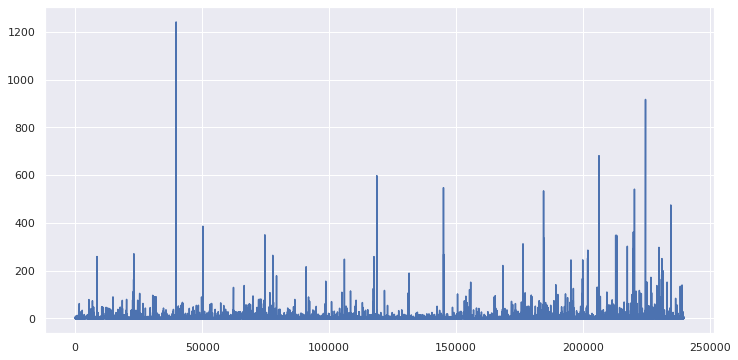

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

legit_scores.plot(figsize = (12, 6))

Next, plot the losses for the fraudulent transactions:



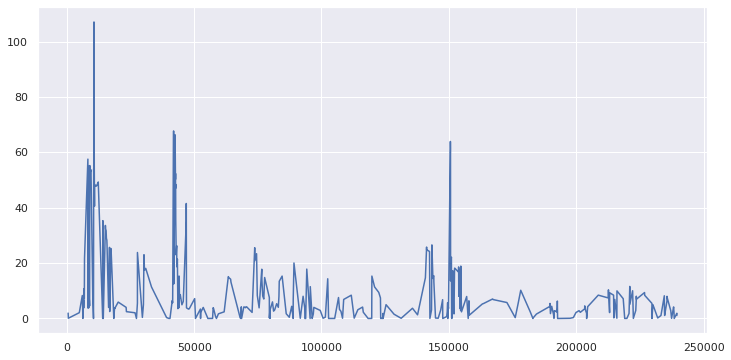

In [19]:
fraud_scores.plot(figsize = (12, 6))

The plots reveal that most of the rows in the dataset representing legitimate transactions incurred a loss of less than 200, while many of the rows in the dataset representing fraudulent transactions incurred a loss greater than 200. Separate the rows on this basis—classifying transactions with a loss of less than 200 as legitimate and transactions with a higher loss as fraudulent—and use a confusion matrix to visualize the results:



Text(89.18, 0.5, 'True label')

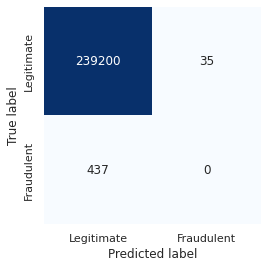

In [20]:
threshold = 200

true_neg = legit_scores[legit_scores < threshold].count()
false_pos = legit_scores[legit_scores >= threshold].count()
true_pos = fraud_scores[fraud_scores >= threshold].count()
false_neg = fraud_scores[fraud_scores < threshold].count()

labels = ['Legitimate', 'Fraudulent']
mat = [[true_neg, false_pos], [false_neg, true_pos]]

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('True label')

# Using PCA to Predict Bearing Failure

One of the classic uses for anomaly detection is to predict failures in rotating machinery. Let’s apply PCA-based anomaly detection to a subset of a dataset published by NASA to predict failures in bearings. The dataset contains vibration data for four bearings supporting a rotating shaft with a radial load of 6,000 pounds applied to it. The bearings were run to failure, and vibration data was captured by high-sensitivity quartz accelerometers at regular intervals until failure occurred.

First, download the CSV file containing the subset that I culled from the larger NASA dataset. Then create a Jupyter notebook and load the data:

In [21]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/jeffprosise/Practical-Machine-Learning/main/Chapter%206/Data/bearings.csv', index_col=0, parse_dates=[0])
df.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


The dataset contains 984 samples. Each sample contains vibration data for four bearings, and the samples were taken 10 minutes apart. Plot the vibration data for all four bearings as a time series:



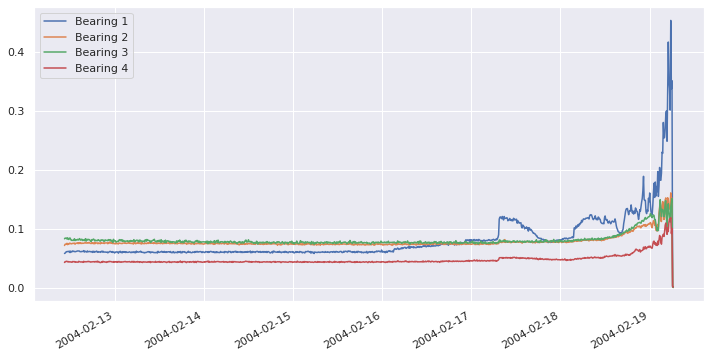

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df.plot(figsize = (12, 6))

About four days into the test, vibrations in bearing 1 began increasing. They spiked a day later, and about two days after that, bearing 1 suffered a catastrophic failure. Our goal is to build a model that recognizes increased vibration in any bearing as a sign of impending failure, and to do it without a labeled dataset.

The next step is to extract samples representing “normal” operation from the dataset (x_train in the following code) and reduce four dimensions to one using PCA—essentially combining the data from all four bearings. Then apply the same PCA transform to the remainder of the dataset (x_test), combine the two partial datasets, and plot the result:

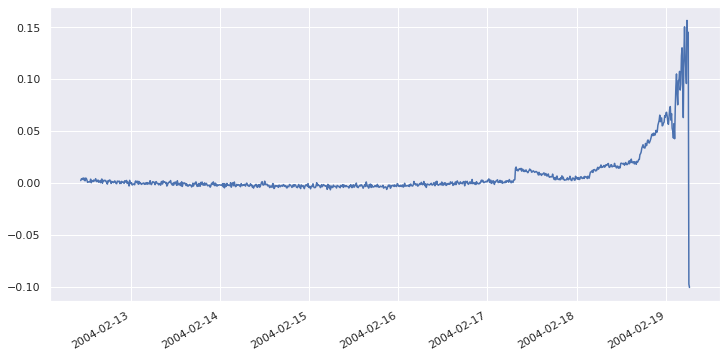

In [23]:
from sklearn.decomposition import PCA

x_train = df['2004-02-12 10:32:39':'2004-02-13 23:42:39']
x_test = df['2004-02-13 23:52:39':]

pca = PCA(n_components=1, random_state=0)
x_train_pca = pd.DataFrame(pca.fit_transform(x_train))
x_train_pca.index = x_train.index

x_test_pca = pd.DataFrame(pca.transform(x_test))
x_test_pca.index = x_test.index

df_pca = pd.concat([x_train_pca, x_test_pca])
df_pca.plot(figsize = (12, 6))
plt.legend().remove()

Now invert the PCA transform and plot the “restored” dataset:



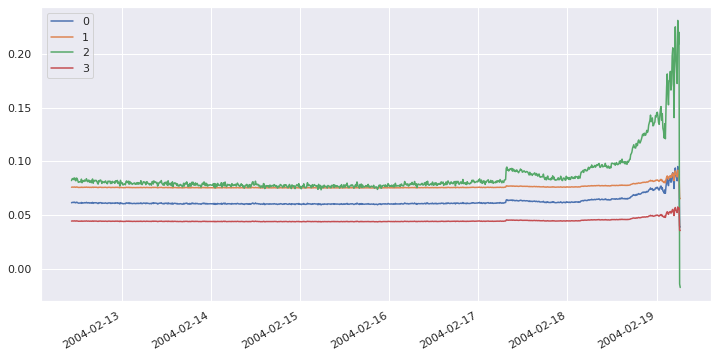

In [24]:
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), index=df_pca.index)
df_restored.plot(figsize = (12, 6))

It is obvious that a loss was incurred by applying and inverting the transform. Let’s define a function that computes the loss in a range of samples, then apply that function to all of the samples in the original dataset and the restored dataset and plot the differences over time:



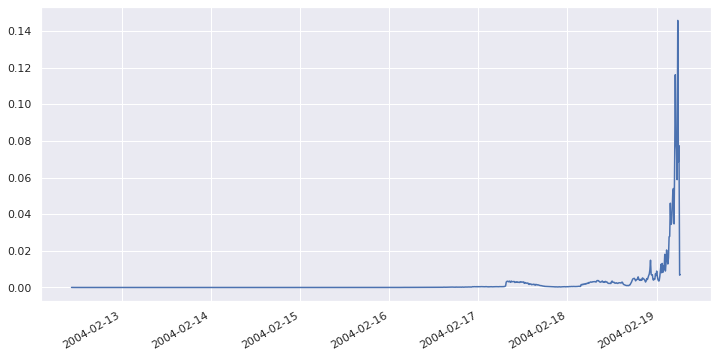

In [25]:
import numpy as np

def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

scores = get_anomaly_scores(df, df_restored)
scores.plot(figsize = (12, 6))

The loss is very small when all four bearings are operating normally, but it begins to rise when one or more bearings exhibit greater-than-normal vibration. From the chart, it’s apparent that when the loss rises above a threshold value of approximately 0.002, that’s an indication a bearing might fail.

Now that you’ve selected a tentative loss threshold, you can use it to detect anomalous behavior in the bearings. Begin by defining a function that takes a sample and returns True or False indicating whether the sample is anomalous by applying and inverting a PCA transform, measuring the loss for each bearing, and comparing it to a specified loss threshold:

In [26]:
def is_anomaly(row, pca, threshold):
    pca_row = pca.transform(row)
    restored_row = pca.inverse_transform(pca_row)
    losses = np.sum((row - restored_row) ** 2)
        
    for loss in losses:
        if loss > threshold:
            return True;

    return False

Apply the function to a row early in the time series that represents normal behavior and confirm that it returns False:



In [27]:
x = df.loc[['2004-02-16 22:52:39']]
is_anomaly(x, pca, 0.002)

False

Apply the function to a row later in the time series that represents anomalous behavior and confirm that it returns True:

In [28]:
x = df.loc[['2004-02-18 22:52:39']]
is_anomaly(x, pca, 0.002)

True

Now apply the function to all the samples in the dataset and shade anomalous samples red in order to visualize when anomalous behavior is detected:



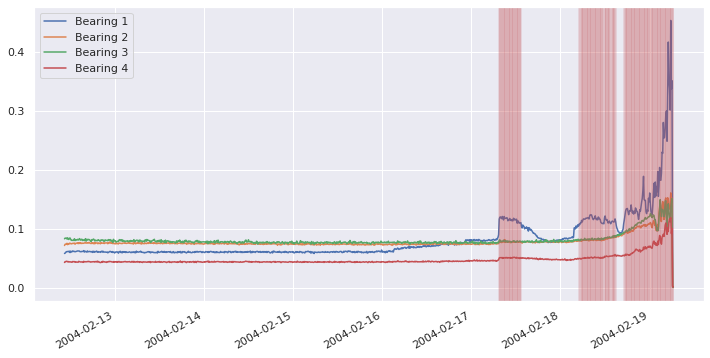

In [29]:
df.plot(figsize = (12, 6))

for index, row in df.iterrows():
    if is_anomaly(pd.DataFrame([row]), pca, 0.002):
        plt.axvline(row.name, color='r', alpha=0.2)

Repeat this procedure, but this time use a loss threshold of 0.0002 rather than 0.002:



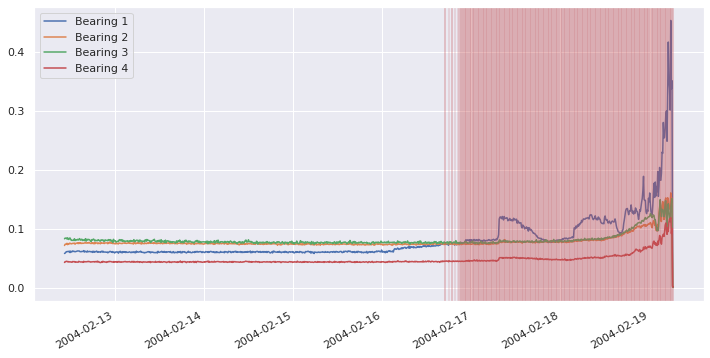

In [30]:
df.plot(figsize = (12, 6))

for index, row in df.iterrows():
    if is_anomaly(pd.DataFrame([row]), pca, 0.0002):
        plt.axvline(row.name, color='r', alpha=0.2)